<a href="https://colab.research.google.com/github/Lilaven/Prediction-Bankrupt-by-machine-learning/blob/master/Predict_Bankrupt_by_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Preparation


Connect Google Drive to Colab

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Import necessary packages

In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch import optim
from sklearn import preprocessing

%matplotlib inline
import matplotlib.pyplot as plt

Read csv file by Pandas

In [3]:
import os
folder_path= "/content/drive/My Drive/AI Project N1"

def filepath(file_name):
  fname = 'Data/{}.csv'.format(file_name)
  fpath = os.path.join(folder_path, fname)
  return(fpath)

df = pd.read_csv(filepath('dataset'), encoding='utf-8', sep=',')
df.head()

,ID_DN,CITY,ENT_TYPE,AGE,LEGAL_GENDER,CAPITAL_AMOUNT,TOTAL_OF_LABORS,MA_NGANH,TienTT_2015,ThuNH_2015,HangTon_2015,TSCoDinh_2015,NoNgan_2015,NoDai_2015,VonCSH_2015,DTThuan_2015,GiaVon_2015,DThuTC_2015,LNThuan_2015,TongLN_2015,LNsauthue_2015,TienTT_2016,ThuNH_2016,HangTon_2016,TSCoDinh_2016,NoNgan_2016,NoDai_2016,VonCSH_2016,DTThuan_2016,GiaVon_2016,DThuTC_2016,LNThuan_2016,TongLN_2016,LNsauthue_2016,TienTT_2017,ThuNH_2017,HangTon_2017,TSCoDinh_2017,NoNgan_2017,NoDai_2017,VonCSH_2017,DTThuan_2017,GiaVon_2017,DThuTC_2017,LNThuan_2017,TongLN_2017,LNsauthue_2017,TienTT_2018,ThuNH_2018,HangTon_2018,TSCoDinh_2018,NoNgan_2018,NoDai_2018,VonCSH_2018,DTThuan_2018,GiaVon_2018,DThuTC_2018,LNThuan_2018,TongLN_2018,LNsauthue_2018,Status
0,ACT2535,0.624625,SC,19.575342,Female,3.600000e+10,50,68,4.224591e+08,1.010693e+10,5.937299e+09,9.703970e+09,2.088461e+10,1.000000e+00,6.953170e+09,1.879817e+10,1.196260e+10,1.495872e+08,5.014032e+08,-9.991240e+07,-9.991240e+07,3.924281e+08,1.717010e+10,1.655965e+09,8.578264e+09,4.052382e+09,1.000000e+00,2.484614e+10,3.855830e+10,3.259164e+10,1.876040e+07,2.489187e+08,-1.766704e+08,-1.766704e+08,3.574686e+09,2.934445e+09,1.619414e+09,8.156943e+09,2.866891e+10,1.000000e+00,3.452408e+10,3.834579e+09,4.330339e+09,1.184226e+07,-2.226256e+09,-2.034441e+09,-2.034441e+09,1.136159e+09,2.271321e+09,1.618178e+09,7.744928e+09,2.892658e+10,1.000000e+00,3.883285e+10,1.072101e+10,3.961619e+09,3.093642e+06,4.862783e+09,4.862783e+09,4.308773e+09,ACT
1,ACT0364,0.624625,SC,14.471233,Male,5.000000e+09,100,71,1.709996e+09,2.205878e+10,7.688406e+09,1.677671e+09,2.682817e+10,2.791818e+08,6.331933e+09,3.085017e+10,2.870113e+10,1.280150e+07,-2.046407e+09,8.475192e+08,2.987592e+08,2.471850e+09,1.164425e+10,7.329164e+09,1.497240e+09,1.594099e+10,4.635771e+08,6.540644e+09,1.671327e+10,1.509299e+10,1.852570e+07,6.407762e+08,6.480786e+08,5.184629e+08,2.892629e+09,1.617797e+10,8.251976e+09,1.332188e+09,2.212973e+10,2.639090e+08,6.357720e+09,2.657614e+10,2.439144e+10,9.384716e+07,2.769413e+08,2.523522e+08,1.966912e+08,3.347424e+09,1.453338e+10,6.785399e+09,1.974041e+09,2.041486e+10,1.000000e+00,6.263990e+09,2.845211e+10,2.593832e+10,6.303738e+07,6.010292e+07,5.597460e+07,4.392401e+07,ACT
2,ACT1689,0.624625,SC,15.191781,Male,6.400000e+09,300,23,2.299011e+09,7.595245e+09,6.538453e+09,1.082475e+09,4.646700e+09,1.300000e+06,1.286718e+10,3.296975e+10,2.593886e+10,1.015550e+07,-2.111740e+08,-2.111740e+08,-2.111740e+08,7.954062e+09,7.163869e+09,6.312931e+09,5.347313e+08,4.742031e+09,1.000000e+00,1.722356e+10,3.458901e+10,2.310517e+10,7.056690e+07,5.356316e+09,5.392680e+09,4.356379e+09,6.660567e+09,5.850101e+09,9.592174e+09,4.471552e+08,5.773379e+09,1.000000e+00,1.677662e+10,3.320228e+10,2.246641e+10,2.297861e+08,5.175020e+09,5.175020e+09,4.140016e+09,2.306497e+09,9.796735e+09,6.148970e+09,4.952394e+08,3.833275e+09,1.000000e+00,1.491417e+10,2.484242e+10,1.866570e+10,6.416322e+07,1.650249e+09,1.650249e+09,1.320199e+09,ACT
3,ACT2928,0.624625,SC,9.336986,Male,7.970000e+11,717,42,2.800000e+12,6.110000e+12,4.030000e+11,3.100000e+11,8.900000e+12,1.010000e+12,8.380000e+11,4.960000e+12,4.610000e+12,1.700000e+11,6.059867e+10,6.144643e+10,6.129465e+10,2.430000e+12,7.140000e+12,4.000000e+11,2.030000e+11,9.630000e+12,8.060000e+11,8.870000e+11,7.380000e+12,7.050000e+12,2.220000e+11,5.490354e+10,6.743830e+10,6.431282e+10,2.590000e+12,3.630000e+12,6.750000e+11,1.710000e+11,6.480000e+12,6.310000e+11,9.230000e+11,1.580000e+13,1.520000e+13,2.350000e+11,7.599879e+10,8.094537e+10,8.004943e+10,1.670000e+12,4.080000e+12,7.040000e+11,1.470000e+11,6.260000e+12,4.280000e+11,9.020000e+11,1.010000e+13,9.750000e+12,2.040000e+11,5.057010e+10,5.539505e+10,4.469575e+10,ACT
4,ACT0607,0.624625,SC,18.893151,Female,3.400000e+11,50,52,2.691355e+10,2.100000e+11,1.651425e+10,6.693537e+10,1.560000e+11,1.673732e+10,4.250000e+11,2.270000e+11,2.190000e+11,2.349406e+09,-4.076757e+09,-5.915186e+09,-5.915186e+09,1.758514e+10,1.440000e+11,1.044513e+08,1.590000e+11,1.850000e+11,5.751614e+10,

Save financial data in separate dataframe

In [4]:
fdf = df.iloc[:, np.r_[8:60]]
fdf.head()

,TienTT_2015,ThuNH_2015,HangTon_2015,TSCoDinh_2015,NoNgan_2015,NoDai_2015,VonCSH_2015,DTThuan_2015,GiaVon_2015,DThuTC_2015,LNThuan_2015,TongLN_2015,LNsauthue_2015,TienTT_2016,ThuNH_2016,HangTon_2016,TSCoDinh_2016,NoNgan_2016,NoDai_2016,VonCSH_2016,DTThuan_2016,GiaVon_2016,DThuTC_2016,LNThuan_2016,TongLN_2016,LNsauthue_2016,TienTT_2017,ThuNH_2017,HangTon_2017,TSCoDinh_2017,NoNgan_2017,NoDai_2017,VonCSH_2017,DTThuan_2017,GiaVon_2017,DThuTC_2017,LNThuan_2017,TongLN_2017,LNsauthue_2017,TienTT_2018,ThuNH_2018,HangTon_2018,TSCoDinh_2018,NoNgan_2018,NoDai_2018,VonCSH_2018,DTThuan_2018,GiaVon_2018,DThuTC_2018,LNThuan_2018,TongLN_2018,LNsauthue_2018
0,4.224591e+08,1.010693e+10,5.937299e+09,9.703970e+09,2.088461e+10,1.000000e+00,6.953170e+09,1.879817e+10,1.196260e+10,1.495872e+08,5.014032e+08,-9.991240e+07,-9.991240e+07,3.924281e+08,1.717010e+10,1.655965e+09,8.578264e+09,4.052382e+09,1.000000e+00,2.484614e+10,3.855830e+10,3.259164e+10,1.876040e+07,2.489187e+08,-1.766704e+08,-1.766704e+08,3.574686e+09,2.934445e+09,1.619414e+09,8.156943e+09,2.866891e+10,1.000000e+00,3.452408e+10,3.834579e+09,4.330339e+09,1.184226e+07,-2.226256e+09,-2.034441e+09,-2.034441e+09,1.136159e+09,2.271321e+09,1.618178e+09,7.744928e+09,2.892658e+10,1.000000e+00,3.883285e+10,1.072101e+10,3.961619e+09,3.093642e+06,4.862783e+09,4.862783e+09,4.308773e+09
1,1.709996e+09,2.205878e+10,7.688406e+09,1.677671e+09,2.682817e+10,2.791818e+08,6.331933e+09,3.085017e+10,2.870113e+10,1.280150e+07,-2.046407e+09,8.475192e+08,2.987592e+08,2.471850e+09,1.164425e+10,7.329164e+09,1.497240e+09,1.594099e+10,4.635771e+08,6.540644e+09,1.671327e+10,1.509299e+10,1.852570e+07,6.407762e+08,6.480786e+08,5.184629e+08,2.892629e+09,1.617797e+10,8.251976e+09,1.332188e+09,2.212973e+10,2.639090e+08,6.357720e+09,2.657614e+10,2.439144e+10,9.384716e+07,2.769413e+08,2.523522e+08,1.966912e+08,3.347424e+09,1.453338e+10,6.785399e+09,1.974041e+09,2.041486e+10,1.000000e+00,6.263990e+09,2.845211e+10,2.593832e+10,6.303738e+07,6.010292e+07,5.597460e+07,4.392401e+07
2,2.299011e+09,7.595245e+09,6.538453e+09,1.082475e+09,4.646700e+09,1.300000e+06,1.286718e+10,3.296975e+10,2.593886e+10,1.015550e+07,-2.111740e+08,-2.111740e+08,-2.111740e+08,7.954062e+09,7.163869e+09,6.312931e+09,5.347313e+08,4.742031e+09,1.000000e+00,1.722356e+10,3.458901e+10,2.310517e+10,7.056690e+07,5.356316e+09,5.392680e+09,4.356379e+09,6.660567e+09,5.850101e+09,9.592174e+09,4.471552e+08,5.773379e+09,1.000000e+00,1.677662e+10,3.320228e+10,2.246641e+10,2.297861e+08,5.175020e+09,5.175020e+09,4.140016e+09,2.306497e+09,9.796735e+09,6.148970e+09,4.952394e+08,3.833275e+09,1.000000e+00,1.491417e+10,2.484242e+10,1.866570e+10,6.416322e+07,1.650249e+09,1.650249e+09,1.320199e+09
3,2.800000e+12,6.110000e+12,4.030000e+11,3.100000e+11,8.900000e+12,1.010000e+12,8.380000e+11,4.960000e+12,4.610000e+12,1.700000e+11,6.059867e+10,6.144643e+10,6.129465e+10,2.430000e+12,7.140000e+12,4.000000e+11,2.030000e+11,9.630000e+12,8.060000e+11,8.870000e+11,7.380000e+12,7.050000e+12,2.220000e+11,5.490354e+10,6.743830e+10,6.431282e+10,2.590000e+12,3.630000e+12,6.750000e+11,1.710000e+11,6.480000e+12,6.310000e+11,9.230000e+11,1.580000e+13,1.520000e+13,2.350000e+11,7.599879e+10,8.094537e+10,8.004943e+10,1.670000e+12,4.080000e+12,7.040000e+11,1.470000e+11,6.260000e+12,4.280000e+11,9.020000e+11,1.010000e+13,9.750000e+12,2.040000e+11,5.057010e+10,5.539505e+10,4.469575e+10
4,2.691355e+10,2.100000e+11,1.651425e+10,6.693537e+10,1.560000e+11,1.673732e+10,4.250000e+11,2.270000e+11,2.190000e+11,2.349406e+09,-4.076757e+09,-5.915186e+09,-5.915186e+09,1.758514e+10,1.440000e+11,1.044513e+08,1.590000e+11,1.850000e+11,5.751614e+10,4.290000e+11,2.890000e+11,2.780000e+11,2.344064e+10,3.799881e+09,3.985734e+09,3.985734e+09,1.285008e+10,1.430000e+11,9.092064e+07,1.440000e+11,1.340000e+11,5.735560e+10,4.300000e+11,2.870000e+11,2.650000e+11,2.636119e+10,2.583694e+09,1.869336e+09,1.036285e+09,2.941259e+10,1.770000e+11,2.764617e+07,1.480000e+11,1.470000e+11,5.388054e+10,4.380000e+11,3.670000e+11,3.440000e+11

Transform non-numerical labels to numerical labels.

In [5]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

# Find all unique value of columns need encoding
u_gender = np.unique(df['LEGAL_GENDER'])
u_ent_type = np.unique(df['ENT_TYPE'])
u_ma_nganh = np.unique(df['MA_NGANH'])
u_status = np.unique(df['Status'])

# Match initial label with new index encoded by LabelEncoder function
le = LabelEncoder()
label_gender = le.fit_transform(df['LEGAL_GENDER'])
mapping_gender = {index: label for index, label in 
                  enumerate(le.classes_)}

label_ent_type = le.fit_transform(df['ENT_TYPE'])
mapping_ent_type = {index: label for index, label in 
                  enumerate(le.classes_)}

label_ma_nganh = le.fit_transform(df['MA_NGANH'])
mapping_ma_nganh= {index: label for index, label in 
                  enumerate(le.classes_)}

label_status = le.fit_transform(df['Status'])
mapping_status = {index: label for index, label in 
                  enumerate(le.classes_)}

mapping_gender, mapping_ent_type, mapping_ma_nganh, mapping_status

({0: 'Female', 1: 'Male'},
 {0: 'LLC1', 1: 'LLC2', 2: 'SC'},
 {0: 1,
  1: 2,
  2: 3,
  3: 5,
  4: 7,
  5: 8,
  6: 10,
  7: 11,
  8: 13,
  9: 14,
  10: 15,
  11: 16,
  12: 17,
  13: 18,
  14: 19,
  15: 20,
  16: 21,
  17: 22,
  18: 23,
  19: 24,
  20: 25,
  21: 26,
  22: 27,
  23: 28,
  24: 29,
  25: 30,
  26: 31,
  27: 32,
  28: 33,
  29: 35,
  30: 36,
  31: 37,
  32: 38,
  33: 39,
  34: 41,
  35: 42,
  36: 43,
  37: 45,
  38: 46,
  39: 47,
  40: 49,
  41: 50,
  42: 52,
  43: 53,
  44: 55,
  45: 56,
  46: 58,
  47: 59,
  48: 61,
  49: 62,
  50: 63,
  51: 64,
  52: 65,
  53: 66,
  54: 68,
  55: 69,
  56: 70,
  57: 71,
  58: 72,
  59: 73,
  60: 74,
  61: 77,
  62: 78,
  63: 79,
  64: 80,
  65: 81,
  66: 82,
  67: 85,
  68: 86,
  69: 90,
  70: 92,
  71: 93,
  72: 95,
  73: 96},
 {0: 'ACT', 1: 'TER'})

One hot encoding some features and update to dataset

In [6]:
#One hot encoding
gender_onehot = pd.get_dummies(df['LEGAL_GENDER'], prefix='Gender')
ent_type_onehot = pd.get_dummies(df['ENT_TYPE'], prefix='Ent_type')
ma_nganh_onehot = pd.get_dummies(df['MA_NGANH'], prefix='Ma_nganh')
status_onehot = pd.get_dummies(df['Status'], prefix='Status')

#Concatenate one hot encoding column to dataset
endf = pd.concat([df[['ID_DN', 'CITY']], ent_type_onehot,
                 df[['AGE']], gender_onehot,
                 df[['CAPITAL_AMOUNT', 'TOTAL_OF_LABORS']], ma_nganh_onehot, fdf, status_onehot], axis=1)
endf

,ID_DN,CITY,Ent_type_LLC1,Ent_type_LLC2,Ent_type_SC,AGE,Gender_Female,Gender_Male,CAPITAL_AMOUNT,TOTAL_OF_LABORS,Ma_nganh_1,Ma_nganh_2,Ma_nganh_3,Ma_nganh_5,Ma_nganh_7,Ma_nganh_8,Ma_nganh_10,Ma_nganh_11,Ma_nganh_13,Ma_nganh_14,Ma_nganh_15,Ma_nganh_16,Ma_nganh_17,Ma_nganh_18,Ma_nganh_19,Ma_nganh_20,Ma_nganh_21,Ma_nganh_22,Ma_nganh_23,Ma_nganh_24,Ma_nganh_25,Ma_nganh_26,Ma_nganh_27,Ma_nganh_28,Ma_nganh_29,Ma_nganh_30,Ma_nganh_31,Ma_nganh_32,Ma_nganh_33,Ma_nganh_35,...,ThuNH_2016,HangTon_2016,TSCoDinh_2016,NoNgan_2016,NoDai_2016,VonCSH_2016,DTThuan_2016,GiaVon_2016,DThuTC_2016,LNThuan_2016,TongLN_2016,LNsauthue_2016,TienTT_2017,ThuNH_2017,HangTon_2017,TSCoDinh_2017,NoNgan_2017,NoDai_2017,VonCSH_2017,DTThuan_2017,GiaVon_2017,DThuTC_2017,LNThuan_2017,TongLN_2017,LNsauthue_2017,TienTT_2018,ThuNH_2018,HangTon_2018,TSCoDinh_2018,NoNgan_2018,NoDai_2018,VonCSH_2018,DTThuan_2018,GiaVon_2018,DThuTC_2018,LNThuan_2018,TongLN_2018,LNsauthue_2018,Status_ACT,Status_TER
0,ACT2535,0.624625,0,0,1,19.575342,1,0,3.600000e+10,50,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1.717010e+10,1.655965e+09,8.578264e+09,4.052382e+09,1.000000e+00,2.484614e+10,3.855830e+10,3.259164e+10,1.876040e+07,2.489187e+08,-1.766704e+08,-1.766704e+08,3.574686e+09,2.934445e+09,1.619414e+09,8.156943e+09,2.866891e+10,1.000000e+00,3.452408e+10,3.834579e+09,4.330339e+09,1.184226e+07,-2.226256e+09,-2.034441e+09,-2.034441e+09,1.136159e+09,2.271321e+09,1.618178e+09,7.744928e+09,2.892658e+10,1.000000e+00,3.883285e+10,1.072101e+10,3.961619e+09,3.093642e+06,4.862783e+09,4.862783e+09,4.308773e+09,1,0
1,ACT0364,0.624625,0,0,1,14.471233,0,1,5.000000e+09,100,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1.164425e+10,7.329164e+09,1.497240e+09,1.594099e+10,4.635771e+08,6.540644e+09,1.671327e+10,1.509299e+10,1.852570e+07,6.407762e+08,6.480786e+08,5.184629e+08,2.892629e+09,1.617797e+10,8.251976e+09,1.332188e+09,2.212973e+10,2.639090e+08,6.357720e+09,2.657614e+10,2.439144e+10,9.384716e+07,2.769413e+08,2.523522e+08,1.966912e+08,3.347424e+09,1.453338e+10,6.785399e+09,1.974041e+09,2.041486e+10,1.000000e+00,6.263990e+09,2.845211e+10,2.593832e+10,6.303738e+07,6.010292e+07,5.597460e+07,4.392401e+07,1,0
2,ACT1689,0.624625,0,0,1,15.191781,0,1,6.400000e+09,300,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,7.163869e+09,6.312931e+09,5.347313e+08,4.742031e+09,1.000000e+00,1.722356e+10,3.458901e+10,2.310517e+10,7.056690e+07,5.356316e+09,5.392680e+09,4.356379e+09,6.660567e+09,5.850101e+09,9.592174e+09,4.471552e+08,5.773379e+09,1.000000e+00,1.677662e+10,3.320228e+10,2.246641e+10,2.297861e+08,5.175020e+09,5.175020e+09,4.140016e+09,2.306497e+09,9.796735e+09,6.148970e+09,4.952394e+08,3.833275e+09,1.000000e+00,1.491417e+10,2.484242e+10,1.866570e+10,6.416322e+07,1.650249e+09,1.650249e+09,1.320199e+09,1,0
3,ACT2928,0.624625,0,0,1,9.336986,0,1,7.970000e+11,717,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,7.140000e+12,4.000000e+11,2.030000e+11,9.630000e+12,8.060000e+11,8.870000e+11,7.380000e+12,7.050000e+12,2.220000e+11,5.490354e+10,6.743830e+10,6.431282e+10,2.590000e+12,3.630000e+12,6.750000e+11,1.710000e+11,6.480000e+12,6.310000e+11,9.230000e+11,1.580000e+13,1.520000e+13,2.350000e+11,7.599879e+10,8.094537e+10,8.004943e+10,1.670000e+12,4.080000e+12,7.040000e+11,1.470000e+11,6.260000e+12,4.280000e+11,9.020000e+11,1.010000e+13,9.750000e+12,2.040000e+11,5.057010e+10,5.539505e+10,4.469575e+10,1,0
4,ACT0607,0.624625,0,0,1,18.893151,1,0,3.400000e+11,50,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1.440000e+11,1.044513e+08,1.590000e+11,1.850000e+11,5.751614e+10,4.290000e+11,2.890000e+11,2.780000e+11,2.344064e+10,3.799881e+09,3.985734e+09,3.985734e+09,1.285008e+10,1.430000e+11,9.092064e+07,1.440000e+11,1.340000e+11,5.735560e+10,4.300000e+11,2.870000e+11,2.650000e+11,2.636119e+10,2.583694e+09,1.869336e+09,1.036285e+09,2.941259e+10,1.770000e+11,2.764617e+07,1.480000e+11,1.470000e+11,5.388054e+10,4.380000e+11,3.670000e+11,3.440000e+

Natural logarithm on financial data

In [7]:
# Save feature dataset và label to numpy array
npdf = endf.to_numpy()
data = npdf[:,1:136] 
label = npdf[:,136:138] 

#Natural logarithm of financial data on training, validation and test set
def logaritdata(ds):
  sign_ds = ds.copy()
  abs_ds = ds.copy().astype(float)
  ln_ds = ds.copy()
  ds_o = ds.copy()
  sign_ds[:,83:135] = np.sign(ds_o[:, 83:135])
  abs_ds[:,83:135] = np.absolute(ds_o[:,83:135])
  ln_ds[:,83:135] = np.multiply(np.log(abs_ds[:,83:135]), sign_ds[:,83:135])
  ds[:,83:135] = ln_ds[:,83:135] 
  return ds

logaritdata(data)

array([[0.624625, 0, 0, ..., 22.304876725175394, 22.304876725175394,
        22.18391904114214],
       [0.624625, 0, 0, ..., 17.91156895073945, 17.84040850291523,
        17.597971698898867],
       [0.624625, 0, 0, ..., 21.22419209709838, 21.22419209709838,
        21.001048545481186],
       ...,
       [0.539675, 1, 0, ..., -20.312488129439117, 16.96100628725078,
        16.737862725175173],
       [0.539675, 1, 0, ..., -16.75534712013392, -16.758514560675877,
        -16.758514560675877],
       [0.539675, 1, 0, ..., 19.811081238356667, 19.809852812996137,
        19.809852812996137]], dtype=object)

Split training set, validation set and test set

In [8]:
from sklearn.model_selection import train_test_split
x, x_test, y, y_test = train_test_split(data,label, test_size=0.15, random_state=2)
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size = 0.1, random_state=2)
x_train.shape, x_valid.shape, x_test.shape, y_train.shape, y_valid.shape, y_test.shape

((4022, 135), (447, 135), (789, 135), (4022, 2), (447, 2), (789, 2))

Rescale data in some numberic data into range (0,1)




In [9]:
def rescaledata(dataset):
  #Rescale AGE
  age = dataset[:,4].reshape(-1,1)
  sage = preprocessing.MinMaxScaler(feature_range= (0,1)).fit_transform(age)
  dataset[:,4].reshape(-1,1)
  dataset[:,4] = sage[:,0]
  #Rescale CAPITAL_AMOUNT
  capital= dataset[:,7].reshape(-1,1)
  scapital = preprocessing.MinMaxScaler(feature_range= (0,1)).fit_transform(capital)
  dataset[:,7].reshape(-1,1)
  dataset[:,7] = scapital[:,0]
  #Rescale TOTAL_OF_LABORS
  totallabor= dataset[:,8].reshape(-1,1)
  stotallabor = preprocessing.MinMaxScaler(feature_range= (0,1)).fit_transform(totallabor)
  dataset[:,8].reshape(-1,1)
  dataset[:,8] = stotallabor[:,0]
  return dataset

rescaledata(x_train)
rescaledata(x_valid)
rescaledata(x_test)

x_train[:, 4:8], x_valid[:, 4:8], x_train[:, 4:8]

(array([[0.2971129803636573, 0, 1, 0.000263492342319939],
        [0.23323482608814486, 0, 1, 0.0005280428868178696],
        [0.3148442829210869, 0, 1, 0.0006338631046170419],
        ...,
        [0.08854285067530437, 1, 0, 0.0001576721245207667],
        [0.03546260515634597, 1, 0, 9.523819601925506e-06],
        [0.08888383725975599, 0, 1, 0.00010476201562118056]], dtype=object),
 array([[0.14517029595947598, 0, 1, 0.0005026588004973676],
        [0.2873255166533263, 0, 1, 0.0009788618746527685],
        [0.277945281995432, 0, 1, 0.008968491229926717],
        ...,
        [0.10653266332551306, 1, 0, 0.005264689542051377],
        [0.2004466778536622, 0, 1, 0.0005026588004973676],
        [0.08810720270770414, 0, 1, 0.0005026588004973676]], dtype=object),
 array([[0.2971129803636573, 0, 1, 0.000263492342319939],
        [0.23323482608814486, 0, 1, 0.0005280428868178696],
        [0.3148442829210869, 0, 1, 0.0006338631046170419],
        ...,
        [0.08854285067530437, 1, 0, 0.00

Tranform numpy array object to float

In [10]:
x_train = np.array(x_train, dtype=float)
x_valid = np.array(x_valid, dtype=float)
x_test = np.array(x_test, dtype=float)
y_train = np.array(y_train, dtype=float)
y_valid = np.array(y_valid, dtype=float)
y_test = np.array(y_test, dtype=float)

Convert numpy array to torch

In [11]:
def convert_to_tensor(x, y):
    x_torch = torch.from_numpy(x).float()
    y_torch = torch.from_numpy(y).float()
    return x_torch, y_torch

x_train_ts, y_train_ts = convert_to_tensor(x_train, y_train)
x_valid_ts, y_valid_ts = convert_to_tensor(x_valid, y_valid)
x_test_ts, y_test_ts = convert_to_tensor(x_test, y_test)

# Model

In [12]:
#Model MLP

class Mymodel1(nn.Module):
    def __init__(self, input, hidden1, hidden2, output):
        super(Mymodel1, self).__init__()
        self.model = nn.Sequential(
            nn.Dropout(p=0.1),
            nn.Linear(input, hidden1),
            nn.Tanh(),
            nn.Dropout(p=0.05),        
            nn.Linear(hidden1, hidden2),
            nn.Tanh(), 
            nn.Linear(hidden2, output),
            nn.Softmax(dim=1),
        )

    def forward(self, input):
        y_pred = self.model(input)
        return y_pred

# Training

In [13]:
from torch.optim import Adam

mean_train_losses = []
mean_valid_losses = []
valid_acc_list = []
N_epocs, batch_size = 50000, 128
input, hidden1, hidden2, output = 135, 64, 8, 2

model = Mymodel1(input, hidden1, hidden2, output)
modelv = Mymodel1(input, hidden1, hidden2, output)
criterion = nn.MSELoss()
optimizer = Adam(model.parameters(), lr=1e-6, eps=1e-8)

for epoch in range(N_epocs):
    model.train()
    train_losses = []
    valid_losses = []
        
    optimizer.zero_grad()
    y_pred = model(x_train_ts)
    loss = criterion(y_pred, y_train_ts)
    loss.backward()
    optimizer.step()    
    train_losses.append(loss.item())
        
    if epoch%1000 == 999:
      model.eval()
      correct = 0
      total = 0
      with torch.no_grad():
        y_pred_v = model(x_valid_ts)
        loss = criterion(y_pred_v, y_valid_ts.long())
        valid_losses.append(loss.item())
        _, predicted = torch.max(y_pred_v, 1)
        _, gt = torch.max(y_valid_ts, 1)
        correct += (predicted == gt).sum().item()
        total += y_valid_ts.size(0)
        
      mean_train_losses.append(np.mean(train_losses))
      mean_valid_losses.append(np.mean(valid_losses))
      
      accuracy = 100*correct/total
      valid_acc_list.append(accuracy)
      print('epoch : {}, train loss : {:.4f}, valid loss : {:.4f}, valid acc : {:.4f}%'\
          .format(epoch+1, np.mean(train_losses), np.mean(valid_losses), accuracy))

epoch : 1000, train loss : 0.2504, valid loss : 0.2474, valid acc : 55.2573%
epoch : 2000, train loss : 0.2429, valid loss : 0.2375, valid acc : 59.0604%
epoch : 3000, train loss : 0.2376, valid loss : 0.2301, valid acc : 63.3110%
epoch : 4000, train loss : 0.2323, valid loss : 0.2239, valid acc : 66.8904%
epoch : 5000, train loss : 0.2280, valid loss : 0.2186, valid acc : 68.6801%
epoch : 6000, train loss : 0.2236, valid loss : 0.2138, valid acc : 68.9038%
epoch : 7000, train loss : 0.2196, valid loss : 0.2094, valid acc : 71.3647%
epoch : 8000, train loss : 0.2162, valid loss : 0.2052, valid acc : 72.0358%
epoch : 9000, train loss : 0.2128, valid loss : 0.2013, valid acc : 73.3781%
epoch : 10000, train loss : 0.2098, valid loss : 0.1977, valid acc : 74.0492%
epoch : 11000, train loss : 0.2076, valid loss : 0.1944, valid acc : 73.8255%
epoch : 12000, train loss : 0.2041, valid loss : 0.1914, valid acc : 74.4966%
epoch : 13000, train loss : 0.2030, valid loss : 0.1887, valid acc : 74.7

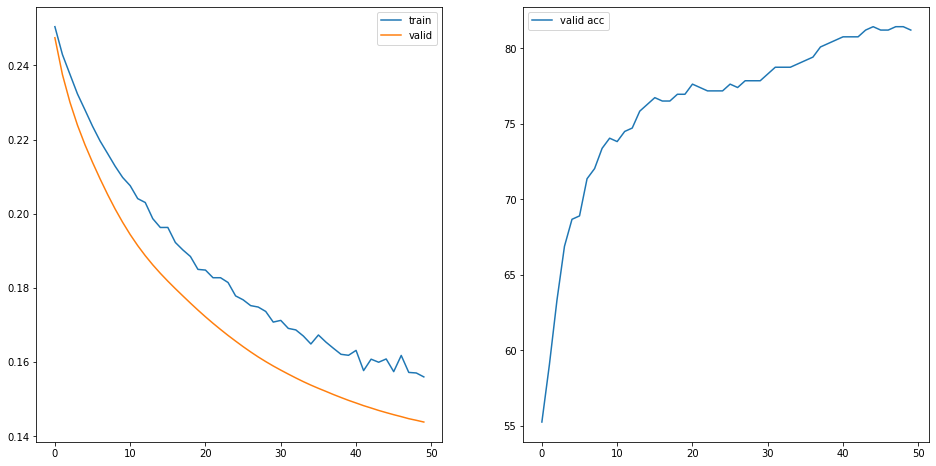

In [14]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
ax1.plot(mean_train_losses, label='train')
ax1.plot(mean_valid_losses, label='valid')
lines, labels = ax1.get_legend_handles_labels()
ax1.legend(lines, labels, loc='best')

ax2.plot(valid_acc_list, label='valid acc')
ax2.legend()

### Acccuracy on Testdata

In [15]:
def test_acc(model):
  correct = 0
  total = 0
  with torch.no_grad():
    for i in range(len(x_test_ts[:,0])):
      y_pred_t = model(x_test_ts)
      _, predicted = torch.max(y_pred_t, 1)
      _, gt = torch.max(y_test_ts, 1)
      correct += (predicted == gt).sum().item()
      total += y_test_ts.size(0)
  accuracy = 100*correct/total
  print('Accuracy of testdata: {:.3f}%'.format(accuracy))

test_acc(model)

Accuracy of testdata: 80.228%
